In [2]:
import pickle
import sncosmo
import numpy as np
import lsst.daf.base as dafBase
import lsst.daf.persistence as dafPersist

import lsst.afw.display.ds9 as ds9

import astropy.coordinates as coord
import astropy.units as u



In [21]:
from astropy.table import Table

def source_distance(src1, src2):
    ra, dec = src1['ra'], src1['dec']
    ra2, dec2 = src2['ra'], src2['dec']
            
    return np.sqrt((float(ra)-float(ra2))**2+(float(dec)-float(dec2))**2)/3.14159*180*3600

def build_light_curve_from_snls_file(data, c):

    bandpasses = ['r']


    lightcurve = {}
    lightcurve['bandpass'] = []
    lightcurve['mjd'] = []
    lightcurve['ra'] = []
    lightcurve['dec'] = []
    lightcurve['flux'] = []
    lightcurve['flux_error'] = []
    lightcurve['zp'] = []
    lightcurve['zpsys'] = []


    for mjd, flux, error in data:

        #print 'yep',visit
        lightcurve['bandpass'].append(str('sdss' + bandpasses[0]))
        lightcurve['mjd'].append(float(mjd))
        lightcurve['ra'].append(c.ra.radian)
        lightcurve['dec'].append(c.dec.radian)
        lightcurve['flux'].append(float(flux))
        lightcurve['flux_error'].append(float(error))
        #lightcurve['flux'].append(src['base_CircularApertureFlux_12_0_flux'])
        #lightcurve['flux_error'].append(src['base_CircularApertureFlux_12_0_fluxSigma'])
        lightcurve['zp'].append(25.0)
        lightcurve['zpsys'].append('ab')

    lc = Table(data=lightcurve)
    return lc

def mean_lc_flux(lc2):
    mjds = []
    m_fluxes = []
    m_error = []
    s_error = []
    i = 0
    while i < len(lc2['mjd']):
        mjd = lc2['mjd'][i]
        j = i+1
        mjds.append(int(mjd))
        m_fluxes.append(lc2['flux'][i])
        m_error.append(lc2['flux_error'][i])
        s_error.append(lc2['flux_error'][i]*lc2['flux_error'][i])
        total = 1.

        while j<len(lc2['mjd']) and int(lc2['mjd'][j]) == int(mjd):

            m_fluxes[-1]+= lc2['flux'][j]*lc2['flux_error'][j]
            m_error[-1] += lc2['flux_error'][j]
            s_error[-1] += (lc2['flux_error'][j]*lc2['flux_error'][j])
            #mjds[-1] += int(lc2['mjd'][j])
            total+=1
            j+=1
        m_fluxes[-1] = np.divide(m_fluxes[-1], m_error[-1] )
        m_error[-1] = np.divide(np.sqrt(s_error[-1]), total)
        i = j
    return mjds, m_fluxes, m_error

def build_lightcurve(source_list):
    """
    Assemble a light curve data table from available files.
    """

    bandpasses = ['r']


    lightcurve = {}
    lightcurve['bandpass'] = []
    lightcurve['mjd'] = []
    lightcurve['ra'] = []
    lightcurve['dec'] = []
    lightcurve['flux'] = []
    lightcurve['flux_error'] = []
    lightcurve['zp'] = []
    lightcurve['zpsys'] = []
    lightcurve['visits'] = []

    for visit, src in source_list:

        #print 'yep',visit
        lightcurve['bandpass'].append(str('sdss' + bandpasses[0]))
        lightcurve['mjd'].append(visit[-1])
        lightcurve['ra'].append(src['coord_ra'])
        lightcurve['dec'].append(src['coord_dec'])
        lightcurve['flux'].append(src['base_PeakLikelihoodFlux_flux'])
        lightcurve['flux_error'].append(src['base_PeakLikelihoodFlux_fluxSigma'])
        lightcurve['visits'].append(visit)
        #lightcurve['flux'].append(src['base_CircularApertureFlux_12_0_flux'])
        #lightcurve['flux_error'].append(src['base_CircularApertureFlux_12_0_fluxSigma'])
        lightcurve['zp'].append(25.0)
        lightcurve['zpsys'].append('ab')
    lightcurve = Table(data=lightcurve)
    return lightcurve


In [4]:
lcs = pickle.load(open('/renoir_data_02/jpreyes/lsst_data/transients_files/transients_filter_r.lc', 'rb'))


print "there are " +str(len(lcs)) +" light curves"

there are 1148 light curves


In [5]:
count = 0
for lc in lcs:
    count += len(lc['flux'])
    
print count

22848


In [6]:
i=1
DATADIR="/renoir_data_02/jpreyes/lsst_data/CFHTLS_master/"
butler = dafPersist.Butler(DATADIR+"/output")
cl = butler.get('calexp', {'visit': 850177 , 'filter':'r' , 'ccd':14})
    
wcs = cl.getWcs()
ds9.mtv(cl, frame=1)
for n, tl in enumerate(lcs):
   

    x, y = wcs.skyToPixel(tl[0]['ra'], tl[0]['dec'])
    #ds9.dot(n, x, y, frame=1, size=2)
    ds9.dot('o', x, y, frame=1, size=10, ctype=ds9.BLUE)
    i+=1
    

/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2016-04-04/lsstsw/miniconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


ds9 doesn't appear to be running (XPA: XPA returned NULL, (;iconify no; raise)), I'll try to exec it for you


In [10]:
import re
f = open('/renoir_data_02/jpreyes/lsst_data/sn_control/J_A+A_523_A7_table9.dat.txt','r')
data_elems = f.read()
#m = re.findall('^06D3.*?\\|(.*?)\\|', data, re.MULTILINE)
elems = re.findall('^(06D3.*?)\\|(.*?)\\|', data_elems, re.MULTILINE)

f = open('/renoir_data_02/jpreyes/lsst_data/sn_control/J_A+A_523_A7_table10.dat.txt','r')
data = f.read()

In [8]:
import lsst.afw.geom as afwGeom
for sn in elems:
    c = coord.SkyCoord(sn[-1], unit=(u.hourangle, u.deg))
    
    try:
        x, y = wcs.skyToPixel(afwGeom.Angle(c.ra.degree, afwGeom.degrees), afwGeom.Angle(c.dec.degree, afwGeom.degrees))

        ds9.dot('o', x, y, frame=1, size=25, ctype= ds9.RED)
        i+=1
    except Exception, e:
        print e

06D3bz


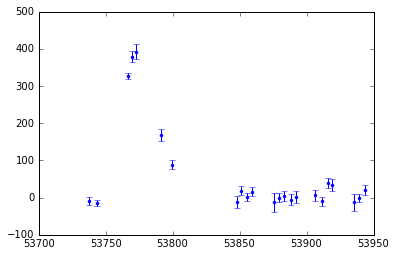

06D3cb


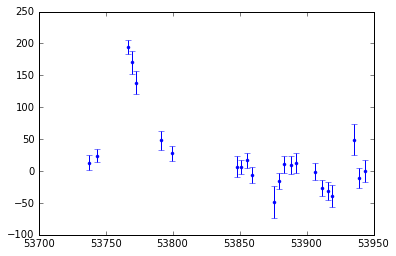

06D3cc


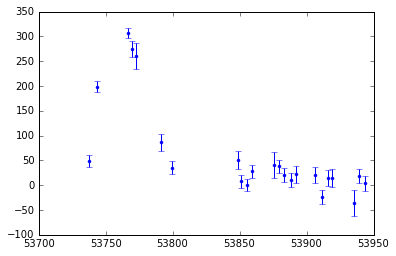

06D3cn


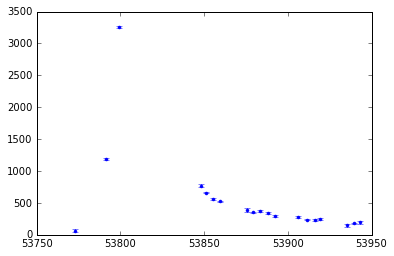

06D3df


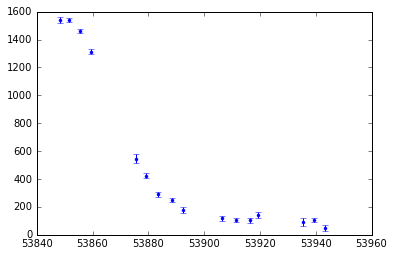

06D3dl


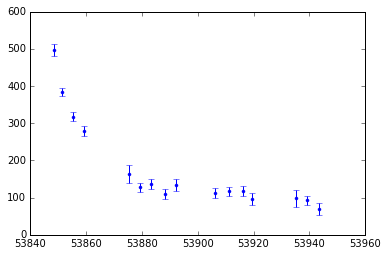

06D3do


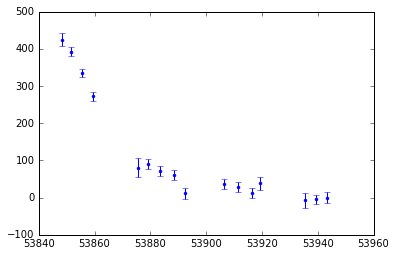

06D3dt


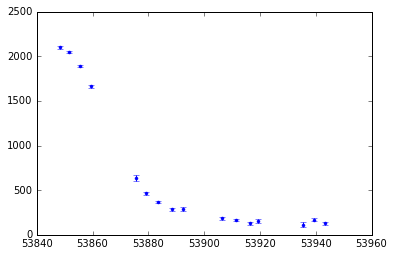

06D3ed


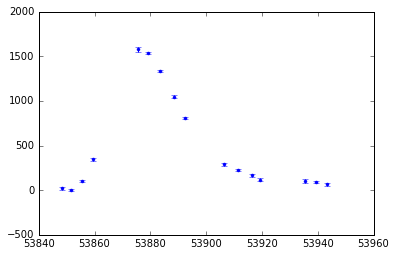

06D3el


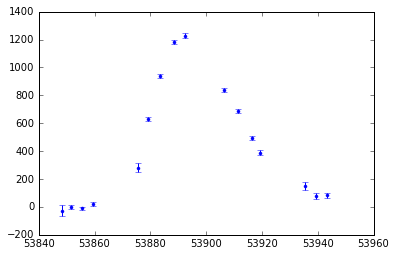

06D3em


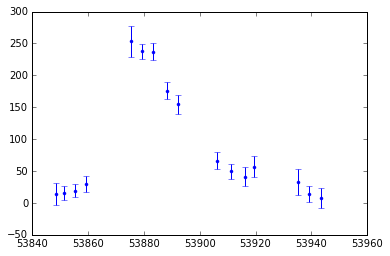

06D3en


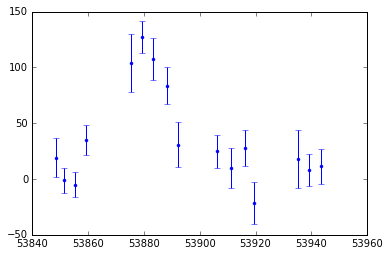

06D3et


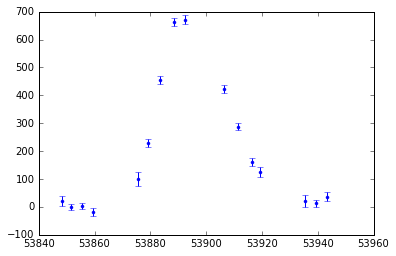

06D3fp


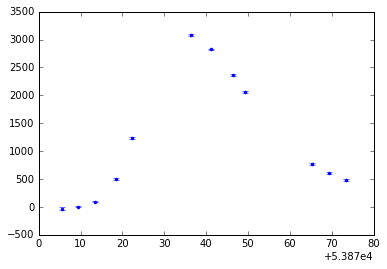

06D3gh


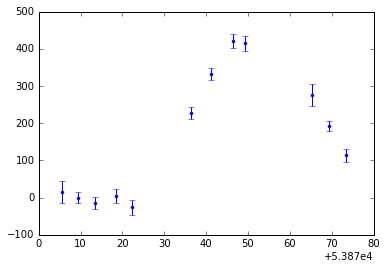

06D3gn


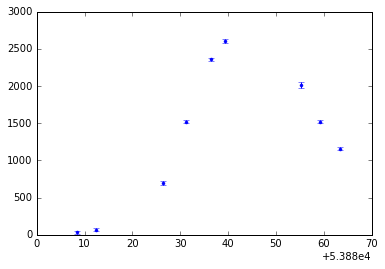

06D3gx


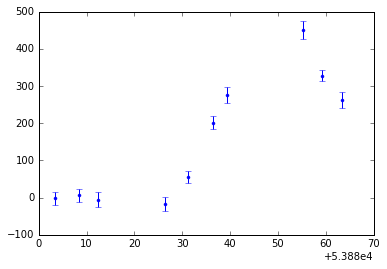

('06D3gx', '14 17 03.234 +52 56 10.510')


In [22]:
import matplotlib.pyplot as plt
%matplotlib inline
snls_array = []
for sn in elems:
    c = coord.SkyCoord(sn[-1], unit=(u.hourangle, u.deg))
    
    m = re.findall('^'+str(sn[0])+'\\|r\\|(.*?)\\|(.*?)\\|(.*?)$', data, re.MULTILINE)

    print sn[0]
    snls_lc = build_light_curve_from_snls_file(m, c)
    plt.errorbar(snls_lc['mjd'], snls_lc['flux'], yerr=snls_lc['flux_error'], fmt='.', color='blue')
    snls_array.append(snls_lc)
    plt.show()
    
pickle.dump(snls_array, open('/renoir_data_02/jpreyes/lsst_data/transients_files/snls_transients_filter_r.lc', 'wb'))
print sn

In [13]:
matches = []
for sn in elems:
    match = False
    c = coord.SkyCoord(sn[-1], unit=(u.hourangle, u.deg))
    
    
    for i, lc in enumerate(lcs):
        #print lc[0]['ra']
        #print lc[0]['dec']
        if source_distance(lc[0], {'ra':c.ra.radian, 'dec':c.dec.radian}) < 2:
            match = True
 
            matches.append((sn[0], i))
            break
    
        #print 'no match'
print 'found ' + str(float(len(matches))/float(len(elems))) 

found 0.705882352941


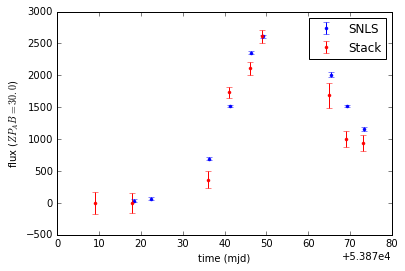

In [467]:
match = matches[11]
m = re.findall('^'+str(match[0])+'\\|r\\|(.*?)\\|(.*?)\\|(.*?)$', data, re.MULTILINE)

snls_lc = build_light_curve_from_snls_file(m)
plt.errorbar(snls_lc['mjd'], snls_lc['flux'], yerr=snls_lc['flux_error'], fmt='.', color='blue', label='SNLS')



lc = lcs[match[-1]]  
lc_copy = lc.copy()
lc_copy.remove_row(0)


#print lc, lc_copy
m_mjd, m_f, m_e = mean_lc_flux(lc_copy)

factor = max(snls_lc['flux']) / max(m_f)
f_mf = np.multiply(m_f, factor)
f_me = np.multiply(m_e, factor)
plt.xlabel('time (mjd)')
plt.ylabel('flux ($ZP_AB=30.0$)')
plt.errorbar(m_mjd, f_mf, yerr=f_me, fmt='.', color='red', label='Stack')
plt.legend(numpoints=1)
plt.show()

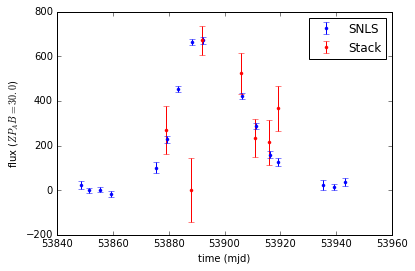

In [469]:
match = matches[9]
m = re.findall('^'+str(match[0])+'\\|r\\|(.*?)\\|(.*?)\\|(.*?)$', data, re.MULTILINE)

snls_lc = build_light_curve_from_snls_file(m)
plt.errorbar(snls_lc['mjd'], snls_lc['flux'], yerr=snls_lc['flux_error'], fmt='.', color='blue', label='SNLS')



lc = lcs[match[-1]]  
lc_copy = lc.copy()
lc_copy.remove_row(-1)


#print lc, lc_copy
m_mjd, m_f, m_e = mean_lc_flux(lc_copy)

factor = max(snls_lc['flux']) / max(m_f)
f_mf = np.multiply(m_f, factor)
f_me = np.multiply(m_e, factor)
plt.xlabel('time (mjd)')
plt.ylabel('flux ($ZP_AB=30.0$)')
plt.errorbar(m_mjd, f_mf, yerr=f_me, fmt='.', color='red', label='Stack')
plt.legend(numpoints=1)
plt.show()

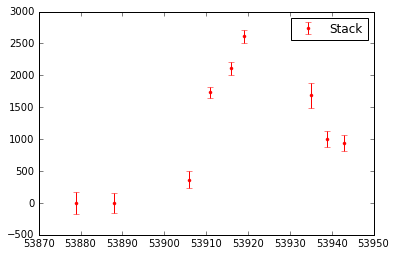

In [464]:
match = matches[-1]
m = re.findall('^'+str(match[0])+'\\|r\\|(.*?)\\|(.*?)\\|(.*?)$', data, re.MULTILINE)

snls_lc = build_light_curve_from_snls_file(m)


#f = plt.errorbar(snls_lc['mjd'], snls_lc['flux'], yerr=snls_lc['flux_error'], fmt='.', color='blue', label='SNLS')
 


lc = lcs[match[-1]]  
lc_copy = lc.copy()
lc_copy.remove_row(0)


#print lc, lc_copy
m_mjd, m_f, m_e = mean_lc_flux(lc_copy)

factor = max(snls_lc['flux']) / max(m_f)
f_mf = np.multiply(m_f, factor)
f_me = np.multiply(m_e, factor)

p = plt.errorbar(m_mjd, f_mf, yerr=f_me, fmt='.', color='red', label='Stack')

ax = plt.gca()
ax.get_xaxis().get_major_formatter().set_useOffset(False)

plt.legend(numpoints=1)

plt.show()

06D3bz


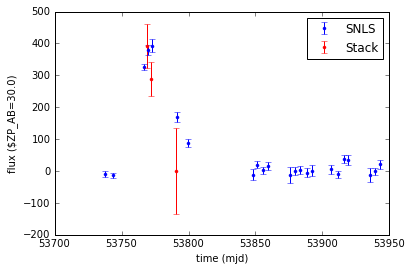

06D3cn


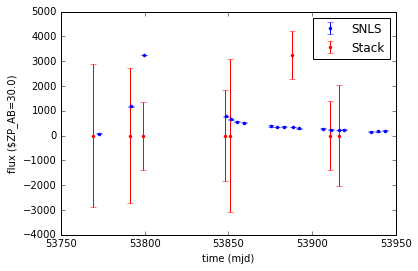

06D3df


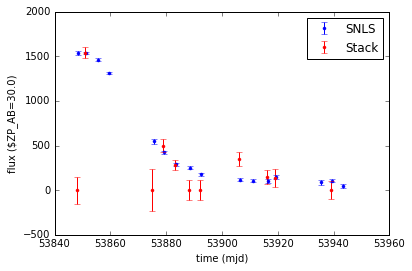

06D3dl


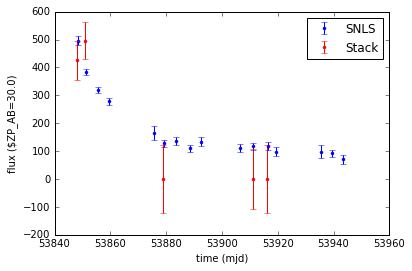

06D3do


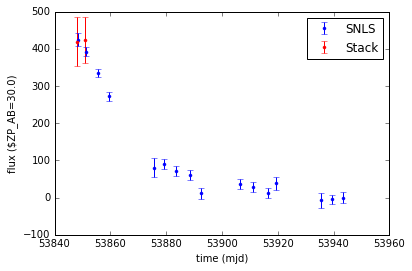

06D3dt


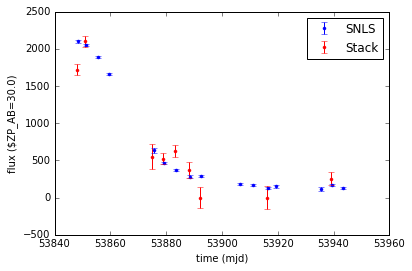

06D3ed


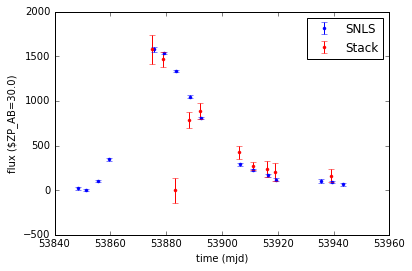

06D3el


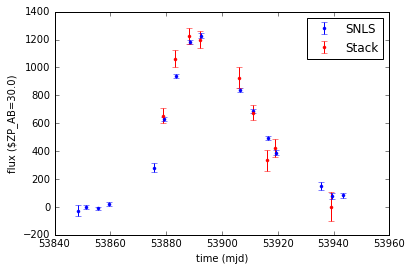

06D3em


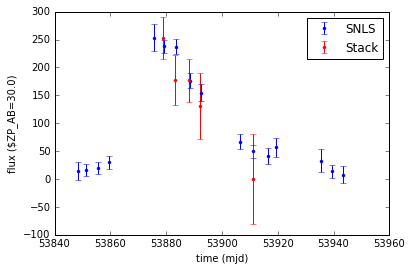

06D3et


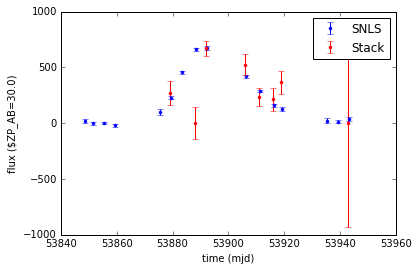

06D3fp


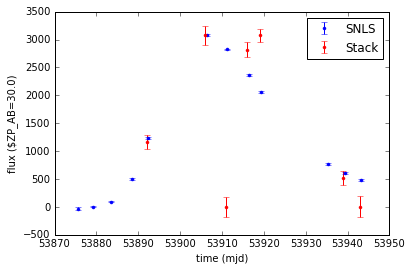

06D3gn


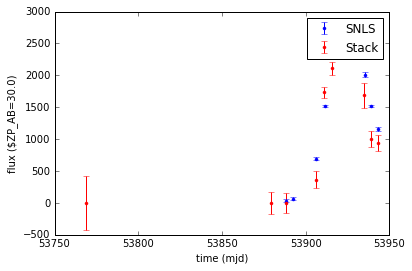

In [465]:
f = open('/renoir_data_02/jpreyes/lsst_data/sn_control/J_A+A_523_A7_table10.dat.txt','r')
data = f.read()
snls_light_curves = []

for match in matches:
    print match[0]
    m = re.findall('^'+str(match[0])+'\\|r\\|(.*?)\\|(.*?)\\|(.*?)$', data, re.MULTILINE)
   
    snls_lc = build_light_curve_from_snls_file(m)
    plt.errorbar(snls_lc['mjd'], snls_lc['flux'], yerr=snls_lc['flux_error'], fmt='.', color='blue', label='SNLS')
    
    
    
    lc = lcs[match[-1]]   
    m_mjd, m_f, m_e = mean_lc_flux(lc)
    
    factor = max(snls_lc['flux']) / max(m_f)
    f_mf = np.multiply(m_f, factor)
    f_me = np.multiply(m_e, factor)
    
    plt.errorbar(m_mjd, f_mf, yerr=f_me, fmt='.', color='red', label='Stack')
    plt.xticks
    
    plt.xlabel('time (mjd)')
    plt.ylabel('flux ($ZP_AB=30.0$)')
    
    ax = plt.gca()
    ax.get_xaxis().get_major_formatter().set_useOffset(False)
    plt.legend(numpoints=1)
    plt.show()

In [318]:
detected = []
not_detected = []
nd_coords = []
for elem in elems:
    found = False
    m = re.findall('^'+str(elem[0])+'\\|(.*?)\\|.*?\\|.*?\\|.*?\\|.*?\\|(.*?)\\|.*?$', data_elems, re.MULTILINE)
   
    for match in matches:
        if match[0] == elem[0]:
            detected.append(float(m[0][-1]))
            found = True
            break
    if found == False:
        not_detected.append(float(m[0][-1]))
        nd_coords.append(m[0][0])
     

In [319]:
print len(detected) + len(not_detected)

17


In [427]:
detected

[0.727,
 0.232,
 0.442,
 0.357,
 0.726,
 0.282,
 0.404,
 0.519,
 0.69,
 0.576,
 0.268,
 0.25]

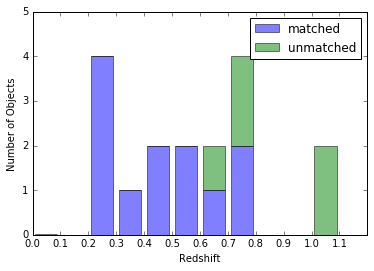

In [435]:

1.1/0.1
binwidth = 0.1
#plt.hist(detected, bins=np.arange(0.0,1.1+binwidth,binwidth), alpha=0.5, label="matched", stacked=True)
plt.hist([detected, not_detected], bins=np.arange(0.0,1.1+binwidth,binwidth), alpha=0.5, label=['matched','unmatched'], stacked=True)
plt.xticks(np.arange(0.0, 1.2, 0.1))
plt.yticks(np.arange(0, 6, 1))
plt.ylabel('Number of Objects')
plt.xlabel('Redshift')
#plt.xlim(xmin=0, xmax=1.1)
plt.legend(loc='upper right')
plt.show()

In [321]:
def get_diaSources_on_field(butler, visit, ccds, s_threshold=5):
    field_diaSources = []

    visit_catalog = None
    mjd = -1
    for ccd in ccds:

        if butler.datasetExists("deepDiff_differenceExp", {'visit': visit , 'filter':'r' , 'ccd':ccd}):

            diffExp = butler.get("deepDiff_differenceExp", {'visit': visit , 'filter':'r' , 'ccd':ccd})
            diaSrcs = butler.get("deepDiff_diaSrc", {'visit': visit , 'filter':'r' , 'ccd':ccd})
            #print "joining ccd "+ str(ccd) + " with " + str(len(diaSrcs)) + "sources"

            fluxes, sigmas = DSTools.get_fluxes_and_sigmas(diaSrcs, "base_PeakLikelihoodFlux_flux")

            m_sigma = np.mean(sigmas)
            t_sigma = s_threshold*m_sigma

            sources = DSTools.get_sources_over_sigma(diaSrcs, t_sigma, "base_PeakLikelihoodFlux_flux")
            #Here we add conditions on the DiaSources set (for instance, no diaSources with negative footprints)
            if visit_catalog == None:
                visit_catalog = diaSrcs.copy()
                visit_catalog.clear()


            for source in sources:
                 visit_catalog.addNew()
                 visit_catalog.append(source)

    #the catalog is complete
    #print "total field has " +str(len(visit_catalog)) +" sources"
    if visit_catalog is not None:
        mjd = float(diffExp.getMetadata().get("MJD-OBS"))
    return visit_catalog, mjd


In [322]:

dsrcs = butler.get('deepDiff_diaSrc', {'visit': 850177 , 'filter':'r' , 'ccd':14})


In [323]:
nd_ref = dsrcs.copy()
nd_ref.clear()
for nd in nd_coords:
    new_src = nd_ref.addNew()
    c = coord.SkyCoord(nd_coords[-1], unit=(u.hourangle, u.deg))
    new_src.setRa(afwGeom.Angle(c.ra.radian))
    new_src.setDec(afwGeom.Angle(c.dec.radian))
    nd_ref.append(new_src)
    

In [348]:
import DiaSourceTools as DSTools
import lsst.afw.table as afwTable

DATADIR="/renoir_data_02/jpreyes/lsst_data/CFHTLS_master/"
butler = dafPersist.Butler(DATADIR+"/output")
visits = butler.queryMetadata("deepDiff_differenceExp", format=['visit', 'date'],dataId={'filter':'r'})
ccds = butler.queryMetadata("deepDiff_differenceExp", format=['ccd'],dataId={'filter':'r'})


catalogs = []

#ccds = [14]
cat_matches = []
for visit, date in visits:
    #if date in dates:
    #   continue
    #We check if there is actually data for the given visit (due to butler limitations) and we chose the first visit for each date
    #if butler.datasetExists("deepDiff_differenceExp", {'visit': visit , 'filter':'r' , 'ccd':ccd}) and date not in dates:
        #print visit
    catalog = get_diaSources_on_field(butler, visit, ccds, s_threshold=1)
    if catalog[0] is not None:
        #print catalog, nd_ref
        cat_match = afwTable.matchRaDec(nd_ref, catalog[0], afwGeom.Angle(2./3600., afwGeom.degrees))
        catalogs.append(catalog)
        cat_matches.append((visit, cat_match))

In [362]:
print t_lc['mjd']

mjd
---
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
  0
